## Exploratory Visualisation: Matrix Method of Food Desert Specification

In this notebook, we will explore the MSOAs for which the matrix specification of food desert has been defined.

In [1]:
import pandas as  pd 
import geopandas as gpd 
import numpy as np 
import json
import geojson

import matplotlib.pyplot as plt 
import seaborn as sns
import folium

plt.style.use('ggplot')
# sns.set_style(style="ggplot", rc=None)#

### 1. Load the Data

In [2]:
# load the shape file
msoa = gpd.read_file("./data/MSOA_2021")

# load the food desert indicator
food_des = pd.read_csv("./data/spmkt_spec_satellite.csv", index_col = 0)

# urban classification
urbs = pd.read_csv("./data/ons_census_2021.csv")

In [20]:
# subset for English MSOAs only
msoa = msoa[msoa["MSOA21CD"].str.contains("E")]
# merge the data
msoa = msoa.merge(food_des, on = "MSOA21CD",how = "left")\
        .merge(urbs[["MSOA21CD","RUC11"]], on = "MSOA21CD", how = "left")
# return urban column
msoa["urbs"] = msoa["RUC11"].str.contains("Urban").map({True:"Urban",False:"Rural"})

In [21]:
# inspect 
msoa.describe(include = 'all')

,MSOA21CD,MSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,value,RUC11,urbs
count,6856,6856,6856.000000,6856.000000,6856.000000,6856.000000,6856,6856,6.717000e+03,6856,6856
unique,6856,6856,NaN,NaN,NaN,NaN,6856,6856,NaN,8,2
top,E02000001,City of London 001,NaN,NaN,NaN,NaN,283e7adc-faef-4736-9a0b-146cb27c72ec,POLYGON ((532153.7029999997 182165.15499999933...,NaN,Urban city and town,Urban
freq,1,1,NaN,NaN,NaN,NaN,1,1,NaN,2966,5658
mean,NaN,NaN,453969.743145,275745.554551,-1.216356,52.370738,NaN,NaN,1.200794e-06,NaN,NaN
std,NaN,NaN,84059.420657,127007.741405,1.216644,1.146381,NaN,NaN,1.912018e-06,NaN,NaN
min,NaN,NaN,91327.000000,11447.000000,-6.302170,49.923300,NaN,NaN,1.092951e-09,NaN,NaN
25%,NaN,NaN,393522.250000,175117.250000,-2.098055,51.463100,NaN,NaN,1.929682e-07,NaN,NaN
50%,NaN,NaN,448350.000000,259002.500000,-1.285650,52.215550,NaN,NaN,5.861599e-07,NaN,NaN
75%,NaN,NaN,524110.500000,389067.500000,-0.208935,53.395700,NaN,NaN,1.323793e-06,NaN,NaN


From this table we can see that the value of food access using the kernel estimate takes a range of $[1.09\times10^{-9}, 2.7 \times 10^{-5}]$. Recall that the higher the value, the better the access to food.

### 2. Static Visualisation
Since we only returned a subset of data for this specification, let's fist have an overview using static visualisation.
Note that the value for each MSOA is computed as follow:
$$ \frac{\sum_i urb_i \times kde_i}{N_u}$$ 
Where i represents the $i$-th pixel within the msoa. $urb_i$ is an indicator variable, taking the value of 1 if the pixel represents a built-up area and 0 otherwise. $kde_i$ is the supermarket kde value at pixel $i$ and $N_u$ is the number of built-up area pixel within the msoa.

Where the access to supermarket is high, the value is high.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


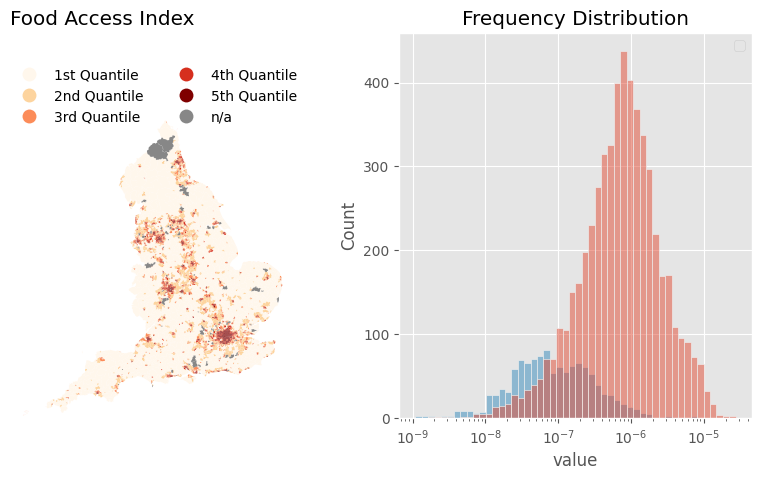

In [10]:
# specify the parameters
var = "value" # column name
title = "Food Access Index"

# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
msoa.plot(column = var, cmap='OrRd',scheme='quantiles',
          missing_kwds = {'color' : "#878787", 'label': "n/a"},
          legend = True,
          legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
# gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title(title, loc = "left")
ax[0].set_axis_off()
# update legend lable
leg = ax[0].get_legend()
labels = ["1st Quantile","2nd Quantile", "3rd Quantile","4th Quantile", "5th Quantile"]
for id, text in enumerate(leg.get_texts()):
    if id < 5 :
        # get the upper and lower bound
        limits = [float(lim) for lim in  text.get_text().split(",")]
        # paraw as lavle
        label = labels[id]
        text.set_text(label)


# plot frequency density
sns.histplot(data = msoa, x = "value", hue = "urbs",log_scale = True, ax = ax[1])
leg.texts[0].set_text("Urban")
leg.texts[1].set_text("Rural")
ax[1].legend().set_title("")
ax[1].set_title("Frequency Distribution")


plt.savefig("./img/fas_kde.png", dpi = 300, bbox_inches = "tight")
plt.show()

### 3. Interactive Visualisation
The interactive panel enables us to narrow down onto smaller MSOAs.

In [5]:
# load msoa as json string
with open("./data/msoa.geojson") as f:
    gj = geojson.load(f)
features = gj['features'][0]


In [7]:
features.keys()

dict_keys(['type', 'id', 'geometry', 'properties'])

In [8]:
# instantiate map
m = folium.Map(location=[51.5, -0.5 ], zoom_start=6, tiles="CartoDB positron")

# add the polygons MSOA
folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=food_des,
    columns=["MSOA21CD", "value"],
    key_on="feature.properties.MSOA21CD",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Food Access Index",
).add_to(m)

In [16]:

food_des.describe()

,value
count,6.717000e+03
mean,1.200794e-06
std,1.912018e-06
min,1.092951e-09
25%,1.929682e-07
50%,5.861599e-07
75%,1.323793e-06
max,2.730745e-05


In [17]:
6717/6856

0.9797257876312718